In [38]:
#https://medium.com/dida-machine-learning/inside-x-rocket-explaining-the-explainable-rocket-534b104c4a08

In [59]:
# https://www.sktime.net/en/v0.24.1/examples/transformation/rocket.html
from sktime.datatypes import check_raise, convert_to
from sktime.transformations.panel.rocket import Rocket, MiniRocket, MiniRocketMultivariate, MultiRocketMultivariate
from matplotlib import pyplot as plt
from sktime.utils.plotting import plot_series
from sklearn.linear_model import RidgeClassifierCV, RidgeCV, SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import ipywidgets as widgets
import numpy as np
import pandas as pd
import os
from sktime.pipeline import make_pipeline

In [60]:
def load_individual_instance(filename, needed_columns):
    df = pd.read_csv(filename)
    for col in needed_columns:
         if not (col in df.columns):
            df[col] = 0.0
    # Ensure all the columns are in the correct order!
    return df[needed_columns]    

In [61]:
pd.options.display.max_rows = 500
needed_columns = ['distanceToPoint']
df = load_individual_instance("/home/simtesting/academic/soprano/SPWorkerTemp/notebooks/predictor/temp-data-64-turtlesim/train/Test_001_25_09_2024_06_05_45.csv", needed_columns)
df

,distanceToPoint
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [62]:
def count_proportion_multivariate(df, num_columns):
    # Counts all the non zero values across multiple columns
    sum_set = sum(df.aggregate(func=np.count_nonzero, axis='columns'))
    return sum_set / (len(df) * num_columns)

In [63]:
len(df)

15

In [64]:
count_proportion_multivariate(df, 10)

0.0

In [65]:
def create_combined_data(base_dir, filenames, needed_columns):
    combined_data_m = map(lambda file: load_individual_instance(base_dir + "/" + file, needed_columns), filenames)
    combined_data = list(combined_data_m)
    print("Check data: ",check_raise(combined_data, mtype="df-list"))
    return combined_data

In [66]:
def find_data_in_dir(csv_directory_train, csv_directory_test, train_split_num):
    files_train = os.listdir(csv_directory_train)
    files_test = os.listdir(csv_directory_test)
    return files_train, files_test

In [67]:
def single_metric_value(m, divisor):
    f = np.floor(m/divisor)
    if (f < 0):
        return 0.0
    else:
        return f

In [68]:
def metrics_map_to_class(metrics, divisor):
      return np.array([single_metric_value(v,divisor) for v in metrics])

In [69]:
def rocket_regression(csv_directory_train, csv_directory_test, train_mfile, test_mfile, needed_columns, metric_name, num_kernels):
    files_train = sorted(os.listdir(csv_directory_train))
    files_test = sorted(os.listdir(csv_directory_test))
    train_data = create_combined_data(csv_directory_train, files_train, needed_columns)
    test_data = create_combined_data(csv_directory_test, files_test, needed_columns)
    train_metrics = pd.read_csv(train_mfile)[metric_name]
    test_metrics = pd.read_csv(test_mfile)[metric_name]
    print("Check data format train_metrics: ",check_raise(train_metrics, mtype="pd.Series"))
    print("Check data format test_metrics: ",check_raise(test_metrics, mtype="pd.Series"))
    
    rocket_pipeline = make_pipeline(MultiRocketMultivariate(num_kernels=num_kernels, n_jobs=-1), StandardScaler(with_mean=False), RidgeCV(alphas=(0.1, 1.0, 10.0))) 
    rocket_pipeline.fit(train_data, train_metrics)
    print("ROCKET fit done!")
    score = rocket_pipeline.score(test_data, test_metrics)
    
    print("Score on test data = ",score)
    print("ROCKET score done!")

    predicted_val = rocket_pipeline.predict(test_data)
    actual_val = test_metrics
    predicted_vs_actual = pd.DataFrame({'predicted_val':predicted_val, 'actual_val':actual_val}, columns = ['predicted_val', 'actual_val'])
    return [rocket_pipeline, predicted_vs_actual]

In [70]:
#base_dir = "./temp-data-1000/"
#metric_name = "uvExposureForHuman"
#needed_columns = ['personDetectionDelay', 'personDetectionPacketLoss', 'personDetectionPacketLossAll', 'distortPersonSector']


In [75]:
base_dir = "./temp-data-64-turtlesim/"
metric_name = "distanceToPoint"
metric_divisor_for_class = 1
needed_columns = ['distortVelocity']

In [76]:
files_train = sorted(os.listdir(csv_directory_train))
files_test = sorted(os.listdir(csv_directory_test))
train_mfile = base_dir + "metrics-train.csv"
test_mfile = base_dir + "metrics-test.csv"
train_data = create_combined_data(csv_directory_train, files_train, needed_columns)
test_data = create_combined_data(csv_directory_test, files_test, needed_columns)
train_metrics = pd.read_csv(train_mfile)[metric_name]
test_metrics = pd.read_csv(test_mfile)[metric_name]
train_metrics


Check data:  True
Check data:  True


0     1.871018
1     1.871018
2     1.766424
3     1.763851
4     1.750251
5     1.871018
6     1.806589
7     1.871018
8     1.751354
9     1.722799
10    1.669983
11    1.871018
12    1.866660
13    1.767147
14    1.805889
15    1.677640
16    1.771942
17    1.734039
18    1.866119
19    1.805889
20    1.766424
21    1.871018
22    1.772639
23    2.210632
24    1.805889
25    1.673329
26    1.866660
27    1.535676
28    1.871018
29    1.772639
30    1.870343
31    1.369825
32    1.871018
33    1.866660
34    1.754453
35    1.753730
36    1.755255
37    1.804266
38    1.871018
Name: distanceToPoint, dtype: float64

In [77]:
csv_directory_train = base_dir + "/train"
csv_directory_test = base_dir + "/test"
mfile_train = base_dir + "metrics-train.csv"
mfile_test = base_dir + "metrics-test.csv"
num_kernels = 10000

In [78]:
rocket, predicted_vs_actual = rocket_regression(csv_directory_train, csv_directory_test, mfile_train, mfile_test, needed_columns, metric_name, num_kernels)
predicted_vs_actual

Check data:  True
Check data:  True
Check data format train_metrics:  True
Check data format test_metrics:  True
ROCKET fit done!
Score on test data =  0.04477991545153537
ROCKET score done!


,predicted_val,actual_val
0,1.777567,1.750251
1,1.831587,1.750251
2,1.792159,1.765037
3,1.887476,1.677640
4,1.872777,1.870343
5,1.870874,1.871018
6,1.712587,1.722799
7,1.677757,1.676940
8,1.716398,1.772639
9,1.614238,1.673329


/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:614: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


[0.015250280317152448, 0.04824294552179285]

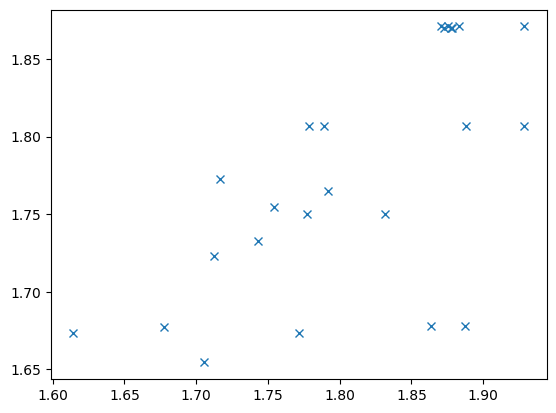

In [90]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.performance_metrics.forecasting import         median_absolute_percentage_error

plt.plot(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"],'x')
mae = MeanAbsoluteError()
mape = median_absolute_percentage_error(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"])
mae = mae(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"])
[mape, mae]

In [19]:
# TODO: quantile regression or classification - probabilistic classification
def rocket_classifier(csv_directory_train, csv_directory_test, train_mfile, test_mfile, needed_columns, metric_name, num_kernels, metric_divisor):
    files_train = sorted(os.listdir(csv_directory_train))
    files_test = sorted(os.listdir(csv_directory_test))
    train_data = create_combined_data(csv_directory_train, files_train, needed_columns)
    test_data = create_combined_data(csv_directory_test, files_test, needed_columns)
    train_metrics = pd.read_csv(train_mfile)[metric_name]
    test_metrics = pd.read_csv(test_mfile)[metric_name]
    print(train_metrics)
    print("Check data format train_metrics: ",check_raise(train_metrics, mtype="pd.Series"))
    print("Check data format test_metrics: ",check_raise(test_metrics, mtype="pd.Series"))
    train_class = metrics_map_to_class(train_metrics, metric_divisor)
    test_class = metrics_map_to_class(test_metrics, metric_divisor)
    print(train_class)
    
    print("Check data format train_metrics: ", check_raise(train_class, mtype="np.ndarray"))
    print("Check data format test_metrics: ", check_raise(test_class, mtype="np.ndarray"))
    
    rocket_pipeline_classifier = make_pipeline(MultiRocketMultivariate(num_kernels=num_kernels, n_jobs=-1), StandardScaler(with_mean=False), RidgeClassifierCV(alphas = np.logspace(-3, 3, 10)))   
    rocket_pipeline_classifier.fit(train_data, train_class)
    print("ROCKET classifier fit done!")
    score = rocket_pipeline_classifier.score(test_data, test_class)
    print("Score on test data = ",score)
    print("ROCKET classifier score done!")
    predicted_class = rocket_pipeline_classifier.predict(test_data)
    actual_class = test_class
    predicted_vs_actual = pd.DataFrame({'predicted_class':predicted_class, 'actual_class':actual_class}, columns = ['predicted_class', 'actual_class'])
    return [rocket_pipeline_classifier, predicted_vs_actual]

In [103]:
base_dir = "./temp-data-400-objectsdelivered-intensity1/"
metric_name = "M1_countObjectsDelivered"
metric_divisor_for_class = 2
needed_columns = ['dosAttackTrigger', 'distortBaseScanPMB2', 'distortBaseScanOmni', 'distortBaseScanTiago', 'packetLossLaserScanOmni', 'packetLossLaserScanPMB2', 'packetLossLaserScanTiago', 'delayBaseScanOmni', 'delayBaseScanPMB2', 'delayBaseScanTiago1']
csv_directory_train = base_dir + "/train"
csv_directory_test = base_dir + "/test"
mfile_train = base_dir + "metrics-train.csv"
mfile_test = base_dir + "metrics-test.csv"
train_metrics = pd.read_csv(mfile_train)
metric_divisor = 3
num_kernels = 10000
rocket, predicted_vs_actual = rocket_classifier(csv_directory_train, csv_directory_test, mfile_train, mfile_test, needed_columns, metric_name, num_kernels, metric_divisor)
predicted_vs_actual

Check data:  True
Check data:  True
0       8.0
1       8.0
2       7.0
3       1.0
4       6.0
5       9.0
6      10.0
7       1.0
8       6.0
9       4.0
10      3.0
11      4.0
12     10.0
13      7.0
14      8.0
15     28.0
16      6.0
17      6.0
18      9.0
19      6.0
20      8.0
21     11.0
22     10.0
23      5.0
24      6.0
25      6.0
26      8.0
27      7.0
28     10.0
29      9.0
30      6.0
31     11.0
32      5.0
33      8.0
34      3.0
35      7.0
36     16.0
37      4.0
38      7.0
39      2.0
40      6.0
41      6.0
42      6.0
43      7.0
44      7.0
45      8.0
46      7.0
47      1.0
48      8.0
49     10.0
50      5.0
51      3.0
52      9.0
53      7.0
54      4.0
55      8.0
56      7.0
57      7.0
58      4.0
59      7.0
60      6.0
61     13.0
62      7.0
63      5.0
64      5.0
65      5.0
66     14.0
67      0.0
68      0.0
69      6.0
70     11.0
71     17.0
72      7.0
73      5.0
74      7.0
75      5.0
76      8.0
77      9.0
78      6.0
79      5.0
80  

,predicted_class,actual_class
0,2.0,2.0
1,2.0,1.0
2,2.0,1.0
3,2.0,2.0
4,3.0,3.0
5,2.0,3.0
6,3.0,2.0
7,2.0,2.0
8,3.0,1.0
9,1.0,2.0


In [36]:
base_dir = "./temp-data-400-misseddeliveries/"
metric_name = "M1_countObjectsMissed"

needed_columns = ['dosAttackTrigger', 'distortBaseScanPMB2', 'distortBaseScanOmni', 'distortBaseScanTiago', 'packetLossLaserScanOmni', 'packetLossLaserScanPMB2', 'packetLossLaserScanTiago', 'delayBaseScanOmni', 'delayBaseScanPMB2', 'delayBaseScanTiago1']
csv_directory_train = base_dir + "/train"
csv_directory_test = base_dir + "/test"
mfile_train = base_dir + "metrics-train.csv"
mfile_test = base_dir + "metrics-test.csv"
train_metrics = pd.read_csv(mfile_train)
metric_divisor = 2
num_kernels = 10000
rocket, predicted_vs_actual = rocket_classifier(csv_directory_train, csv_directory_test, mfile_train, mfile_test, needed_columns, metric_name, num_kernels, metric_divisor)
predicted_vs_actual

Check data:  True
Check data:  True
0      1.0
1      1.0
2      2.0
3      5.0
4      0.0
5      0.0
6      0.0
7      5.0
8      0.0
9      3.0
10     3.0
11     2.0
12     0.0
13     1.0
14     1.0
15     2.0
16     0.0
17     1.0
18     0.0
19     1.0
20     0.0
21     0.0
22     0.0
23     3.0
24     0.0
25     0.0
26     0.0
27     0.0
28     0.0
29     1.0
30     0.0
31     0.0
32     2.0
33     0.0
34     3.0
35     2.0
36     3.0
37     2.0
38     1.0
39     4.0
40     1.0
41     0.0
42     0.0
43     0.0
44     1.0
45     0.0
46     0.0
47     5.0
48     1.0
49     0.0
50     2.0
51     3.0
52     0.0
53     1.0
54     2.0
55     0.0
56     0.0
57     1.0
58     2.0
59     1.0
60     1.0
61     2.0
62     0.0
63     2.0
64     2.0
65     1.0
66     0.0
67     0.0
68     0.0
69     0.0
70     0.0
71     1.0
72     2.0
73     1.0
74     0.0
75     1.0
76     0.0
77     2.0
78     0.0
79     1.0
80     0.0
81     0.0
82     2.0
83     1.0
84     0.0
85     1.0
86     1.0
87     

,predicted_class,actual_class
0,1.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,1.0,0.0


In [31]:
def compare_prediction_and_actual(classifier, divisor_for_metric_class):
    files_test = sorted(os.listdir(csv_directory_test))
    test_num_max = len(files_test)
    test_data = create_combined_data(csv_directory_test, files_test, needed_columns)
    test_metrics = pd.read_csv(mfile_test)
    actual_class = metrics_map_to_class(test_metrics[metric_name], divisor_for_metric_class)
    actual_val = test_metrics[metric_name]
    predicted_class = classifier.predict(test_data)
    predicted_val = rocket.predict(test_data)
    predicted_vs_actual = pd.DataFrame({'predicted_class':predicted_class, 'actual_class':actual_class, 'predicted_val':predicted_val, 'actual_val':actual_val}, columns = ['predicted_class', 'actual_class', 'predicted_val', 'actual_val'])    
    return predicted_vs_actual

In [31]:
base_dir = "./temp-data-400-objectsdelivered/"
metric_name = "M1_countObjectsDelivered"

needed_columns = ['dosAttackTrigger', 'distortBaseScanPMB2', 'distortBaseScanOmni', 'distortBaseScanTiago', 'packetLossLaserScanOmni', 'packetLossLaserScanPMB2', 'packetLossLaserScanTiago', 'delayBaseScanOmni', 'delayBaseScanPMB2', 'delayBaseScanTiago1']
csv_directory_train = base_dir + "/train"
csv_directory_test = base_dir + "/test"
mfile_train = base_dir + "metrics-train.csv"
mfile_test = base_dir + "metrics-test.csv"
train_metrics = pd.read_csv(mfile_train)
metric_divisor = 3
num_kernels = 20000
rocket, predicted_vs_actual = rocket_classifier(csv_directory_train, csv_directory_test, mfile_train, mfile_test, needed_columns, metric_name, num_kernels, metric_divisor)
confusion_matrix(predicted_vs_actual["predicted_class"], predicted_vs_actual["actual_class"])


Check data:  True
Check data:  True
0       8.0
1       8.0
2       7.0
3       1.0
4       6.0
5       9.0
6      10.0
7       1.0
8       6.0
9       4.0
10      3.0
11      4.0
12     10.0
13      7.0
14      8.0
15     28.0
16      6.0
17      6.0
18      9.0
19      6.0
20      8.0
21     11.0
22     10.0
23      5.0
24      6.0
25      6.0
26      8.0
27      7.0
28     10.0
29      9.0
30      6.0
31     11.0
32      5.0
33      8.0
34      3.0
35      7.0
36     16.0
37      4.0
38      7.0
39      2.0
40      6.0
41      6.0
42      6.0
43      7.0
44      7.0
45      8.0
46      7.0
47      1.0
48      8.0
49     10.0
50      5.0
51      3.0
52      9.0
53      7.0
54      4.0
55      8.0
56      7.0
57      7.0
58      4.0
59      7.0
60      6.0
61     13.0
62      7.0
63      5.0
64      5.0
65      5.0
66     14.0
67      0.0
68      0.0
69      6.0
70     11.0
71     17.0
72      7.0
73      5.0
74      7.0
75      5.0
76      8.0
77      9.0
78      6.0
79      5.0
80  

,predicted_class,actual_class
0,2.0,2.0
1,2.0,1.0
2,2.0,1.0
3,2.0,2.0
4,2.0,3.0
5,2.0,3.0
6,2.0,2.0
7,2.0,2.0
8,2.0,1.0
9,2.0,2.0


In [30]:
base_dir = "./temp-data-400-objectsdelivered-multi/"
metric_name = "M1_countObjectsDelivered"

needed_columns = ['dosAttackTrigger', 'distortBaseScanPMB2', 'distortBaseScanOmni', 'distortBaseScanTiago', 'packetLossLaserScanOmni', 'packetLossLaserScanPMB2', 'packetLossLaserScanTiago', 'delayBaseScanOmni', 'delayBaseScanPMB2', 'delayBaseScanTiago1']
csv_directory_train = base_dir + "/train"
csv_directory_test = base_dir + "/test"
mfile_train = base_dir + "metrics-train.csv"
mfile_test = base_dir + "metrics-test.csv"
train_metrics = pd.read_csv(mfile_train)
metric_divisor = 3
num_kernels = 10000
rocket, predicted_vs_actual = rocket_classifier(csv_directory_train, csv_directory_test, mfile_train, mfile_test, needed_columns, metric_name, num_kernels, metric_divisor)
predicted_vs_actual

Check data:  True
Check data:  True
0       8.0
1       8.0
2       7.0
3       1.0
4       6.0
       ... 
1176    9.0
1177    7.0
1178    7.0
1179    4.0
1180    8.0
Name: M1_countObjectsDelivered, Length: 1181, dtype: float64
Check data format train_metrics:  True
Check data format test_metrics:  True
[2. 2. 2. ... 2. 1. 2.]
Check data format train_metrics:  True
Check data format test_metrics:  True
ROCKET classifier fit done!
Score on test data =  0.5919395465994962
ROCKET classifier score done!


,predicted_class,actual_class
0,2.0,1.0
1,2.0,2.0
2,2.0,2.0
3,2.0,2.0
4,2.0,2.0
5,2.0,2.0
6,1.0,1.0
7,2.0,1.0
8,2.0,1.0
9,1.0,3.0


In [36]:
base_dir = "./temp-data-400-objectsdelivered-augmented/"
metric_name = "M1_countObjectsDelivered"

needed_columns = ['dosAttackTrigger', 'distortBaseScanPMB2', 'distortBaseScanOmni', 'distortBaseScanTiago', 'packetLossLaserScanOmni', 'packetLossLaserScanPMB2', 'packetLossLaserScanTiago', 'delayBaseScanOmni', 'delayBaseScanPMB2', 'delayBaseScanTiago1']
csv_directory_train = base_dir + "/train"
csv_directory_test = base_dir + "/test"
mfile_train = base_dir + "metrics-train.csv"
mfile_test = base_dir + "metrics-test.csv"
train_metrics = pd.read_csv(mfile_train)
metric_divisor = 3
num_kernels = 10000
rocket, predicted_vs_actual = rocket_classifier(csv_directory_train, csv_directory_test, mfile_train, mfile_test, needed_columns, metric_name, num_kernels, metric_divisor)


Check data:  True
Check data:  True
0       8.0
1       8.0
2       8.0
3       8.0
4       8.0
       ... 
4719    4.0
4720    8.0
4721    8.0
4722    8.0
4723    8.0
Name: M1_countObjectsDelivered, Length: 4724, dtype: float64
Check data format train_metrics:  True
Check data format test_metrics:  True
[2. 2. 2. ... 2. 2. 2.]
Check data format train_metrics:  True
Check data format test_metrics:  True
ROCKET classifier fit done!
Score on test data =  0.5295969773299748
ROCKET classifier score done!


In [91]:
def plot_cm(norm="all"):
    cm = confusion_matrix(predicted_vs_actual["actual_class"], predicted_vs_actual["predicted_class"], labels=rocket.classes_, normalize=norm)
    cmd = ConfusionMatrixDisplay(cm)
    plt.rcParams.update({'font.size': 6, 'font.weight': 'bold'})
    cmd.plot()
    
    

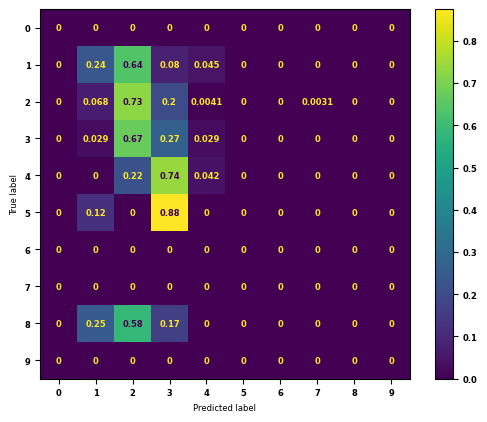

In [92]:
plot_cm(norm="true")

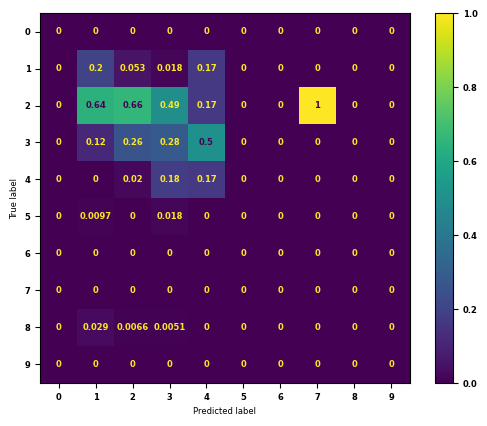

In [93]:
plot_cm(norm="pred")

In [96]:
sum(predicted_vs_actual["actual_class"]==1.0)

88

In [95]:
sum(predicted_vs_actual["actual_class"]==1.0) / len(predicted_vs_actual)

0.055415617128463476

In [68]:
0.2 / 0.0554

3.6101083032490977

In [97]:
0.2+0.64+0.12+0.0097+0.029

0.9987000000000001